<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Buddhika/Research_IT22564122_Hybrid_Model(ConvNeXtTiny_%2B_EfficientNetV2B0)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from zipfile import ZipFile
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import MobileNetV2, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
import tensorflow.keras.backend as K


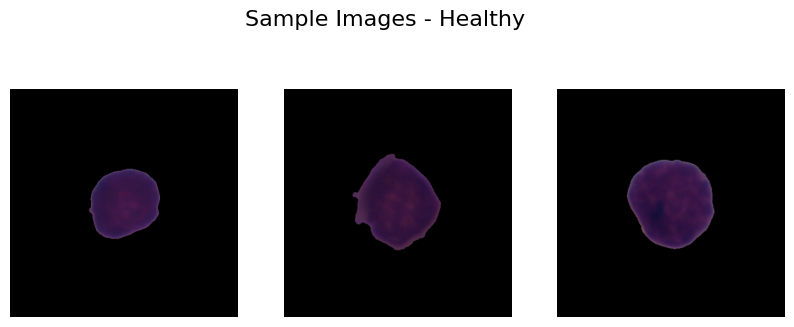

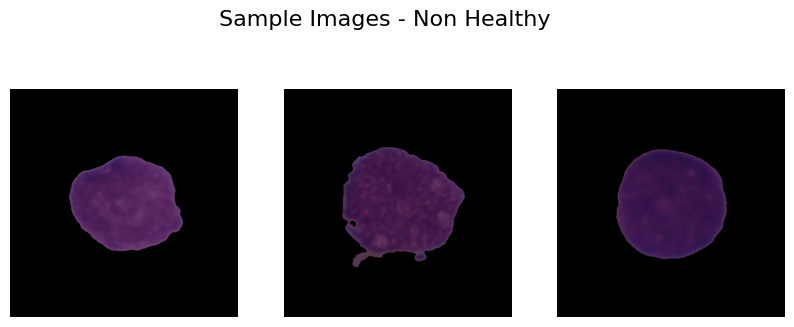

In [3]:
path = '/content/drive/MyDrive/New folder'
classes = ['Healthy', 'Non Healthy']

# ==========================================
# 3. VISUALIZE SAMPLE IMAGES
# ==========================================
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'Sample Images - {cat}', fontsize=16)

    for i in range(3):
        img = np.array(Image.open(os.path.join(image_dir, images[np.random.randint(len(images))])))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [8]:
# ==========================================
# 4. PARAMETERS
# ==========================================
IMG_SIZE = 256
BATCH_SIZE = 64
EPOCHS_PHASE1 = 20
EPOCHS_PHASE2 = 20
SPLIT = 0.2

# ==========================================
# 5. LOAD & PREPROCESS DATA
# ==========================================
X, Y = [], []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.bmp')

    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # IMPORTANT
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        Y.append(i)

X = np.array(X, dtype="float32")
Y = np.array(Y)

Y_cat = keras.utils.to_categorical(Y, num_classes=len(classes))

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y_cat, test_size=SPLIT, random_state=42, stratify=Y
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}")

Train: (837, 256, 256, 3), Validation: (210, 256, 256, 3)


In [9]:
# ==========================================
# 6. CLASS WEIGHTS (OPTIONAL BUT RECOMMENDED)
# ==========================================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y),
    y=Y
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.9914772727272727), 1: np.float64(1.0086705202312138)}


In [10]:
# ==========================================
# 7. DATA AUGMENTATION
# ==========================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
], name="augmentation")


In [11]:
def cbam_block(input_tensor, ratio=8):
    channel = input_tensor.shape[-1]

    # ----- Channel Attention -----
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = layers.GlobalMaxPooling2D()(input_tensor)

    shared_dense_1 = layers.Dense(channel // ratio, activation='relu')
    shared_dense_2 = layers.Dense(channel, activation='sigmoid')

    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)

    x = layers.Multiply()([input_tensor, channel_attention])

    # ----- Spatial Attention -----
    avg_pool_spatial = layers.Lambda(
        lambda x: K.mean(x, axis=-1, keepdims=True)
    )(x)
    max_pool_spatial = layers.Lambda(
        lambda x: K.max(x, axis=-1, keepdims=True)
    )(x)

    spatial_attention = layers.Concatenate(axis=-1)(
        [avg_pool_spatial, max_pool_spatial]
    )
    spatial_attention = layers.Conv2D(
        1, kernel_size=7, padding="same", activation="sigmoid"
    )(spatial_attention)

    x = layers.Multiply()([x, spatial_attention])

    return x


In [12]:
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augmentation(input_layer)

mobile_input = mobilenet_preprocess(x)
dense_input = densenet_preprocess(x)

# =======================
# MobileNetV2 Branch
# =======================
base_mobile = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=mobile_input
)
base_mobile.trainable = False

mobile_feat = base_mobile.output
mobile_feat = cbam_block(mobile_feat)
mobile_feat = layers.GlobalAveragePooling2D()(mobile_feat)

# =======================
# DenseNet121 Branch
# =======================
base_dense = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=dense_input
)
base_dense.trainable = False

dense_feat = base_dense.output
dense_feat = cbam_block(dense_feat)
dense_feat = layers.GlobalAveragePooling2D()(dense_feat)

# =======================
# Feature Fusion
# =======================
combined = layers.Concatenate()([mobile_feat, dense_feat])

# =======================
# Classification Head
# =======================
x = layers.Dense(512, activation='relu')(combined)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

output = layers.Dense(len(classes), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.summary()


/tmp/ipython-input-2274094767.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobile = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_1       │ (None, 256, 256,  │          0 │ augmentation[0][… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ true_divide_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_2       │ (None, 256, 256,  │          0 │ add[0][0]         │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ true_divide_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r

 Total params: 11,285,096 (43.05 MB)

 Trainable params: 1,988,072 (7.58 MB)

 Non-trainable params: 9,297,024 (35.47 MB)

In [13]:
def grad_cam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap.numpy()


In [14]:
def show_gradcam(img_path, model, last_conv_layer):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(img, axis=0)
    img_array = img_array.astype("float32")

    heatmap = grad_cam(model, img_array, last_conv_layer)

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed)
    plt.axis("off")
    plt.title("Grad-CAM")
    plt.show()


In [15]:
# ==========================================
# 9. COMPILE (PHASE 1)
# ==========================================
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)


In [16]:
# ==========================================
# 10. TRAINING – PHASE 1 (FEATURE EXTRACTION)
# ==========================================
history_1 = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS_PHASE1,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5521 - loss: 1.1332 - val_accuracy: 0.5857 - val_loss: 0.6449
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 524ms/step - accuracy: 0.7077 - loss: 0.9192 - val_accuracy: 0.6667 - val_loss: 0.6185
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - accuracy: 0.6939 - loss: 0.8589 - val_accuracy: 0.6952 - val_loss: 0.6161
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 529ms/step - accuracy: 0.6954 - loss: 0.8931 - val_accuracy: 0.6905 - val_loss: 0.6163
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - accuracy: 0.6948 - loss: 0.8265 - val_accuracy: 0.7667 - val_loss: 0.5970
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 534ms/step - accuracy: 0.6757 - loss: 0.8963 - val_accuracy: 0.7571 - val_loss: 0.5861
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 535ms/step - accuracy: 0.6855 - loss: 0.8695 - val_accuracy: 0.7810 - val_loss: 0.5785
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 530ms/step - accuracy: 0.6709 - loss: 0.8217 - val_accuracy: 0.75

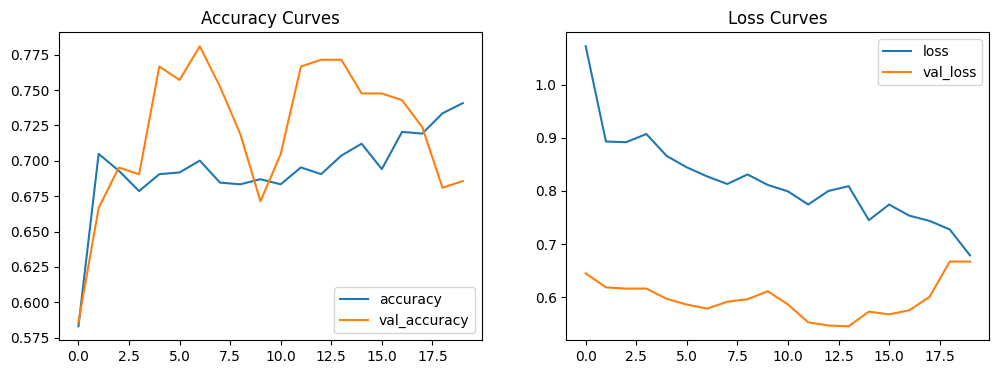

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


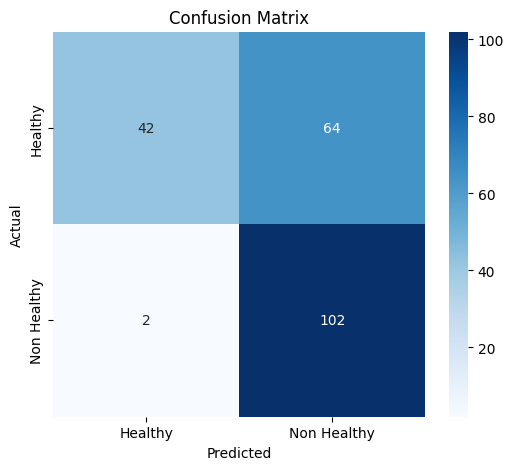

In [17]:
# Plot Accuracy and Loss
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
history_df = pd.DataFrame(history_1.history)

history_df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
ax[0].set_title('Accuracy Curves')

history_df[['loss', 'val_loss']].plot(ax=ax[1])
ax[1].set_title('Loss Curves')
plt.show()

# Confusion Matrix
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# ==========================================
# 11. FINE-TUNING (PHASE 2)
# ==========================================
for layer in base_mobile.layers[-30:]:
    layer.trainable = True

for layer in base_dense.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history_2 = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS_PHASE2,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    verbose=1
)


model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history_2 = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS_PHASE2,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5849 - loss: 1.0081 - val_accuracy: 0.6952 - val_loss: 0.6441
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 608ms/step - accuracy: 0.6676 - loss: 0.8896 - val_accuracy: 0.7048 - val_loss: 0.6291
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 602ms/step - accuracy: 0.6051 - loss: 0.9178 - val_accuracy: 0.7190 - val_loss: 0.6146
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 612ms/step - accuracy: 0.6400 - loss: 0.8445 - val_accuracy: 0.7190 - val_loss: 0.5998
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 607ms/step - accuracy: 0.6656 - loss: 0.8593 - val_accuracy: 0.7238 - val_loss: 0.5937
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 591ms/step - accuracy: 0.6520 - loss: 0.9159 - val_accuracy: 0.7333 - val_loss: 0.5845
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 600ms/step - accuracy: 0.6296 - loss: 0.9148 - val_accuracy: 0.7429 - val_loss: 0.5682
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 597ms/step - accuracy: 0.6740 - loss: 0.8983 - val_accuracy: 0.75

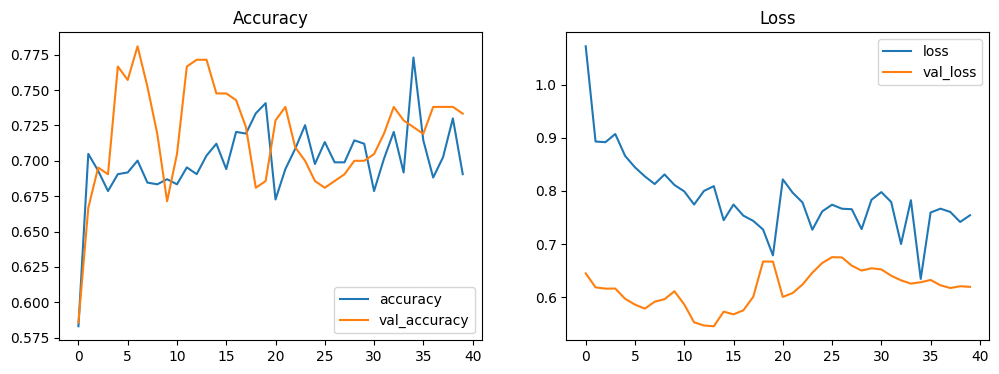

In [19]:
# ==========================================
# 12. TRAINING CURVES
# ==========================================
history = pd.concat([
    pd.DataFrame(history_1.history),
    pd.DataFrame(history_2.history)
], ignore_index=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
history[['accuracy', 'val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy")

history[['loss', 'val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss")
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
              precision    recall  f1-score   support

     Healthy       0.83      0.59      0.69       106
 Non Healthy       0.68      0.88      0.76       104

    accuracy                           0.73       210
   macro avg       0.75      0.73      0.73       210
weighted avg       0.75      0.73      0.73       210



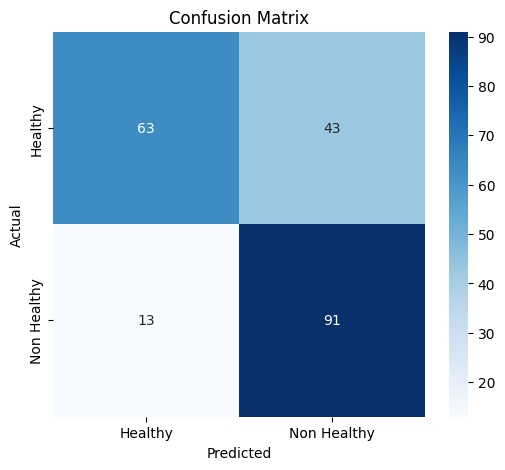

In [20]:
# ==========================================
# 13. EVALUATION
# ==========================================
Y_pred = model.predict(X_val)
Y_pred_cls = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

print(classification_report(Y_true, Y_pred_cls, target_names=classes))

cm = confusion_matrix(Y_true, Y_pred_cls)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
model_path="/content/drive/MyDrive/New folder/Hybrid_Model(ConvNeXtTiny_+_EfficientNetV2B0).h5"

In [30]:
model_path_keras = model_path.replace('.h5', '.keras')
model.save(model_path_keras, save_format='keras')